### Stpe0: Import library and Setting
- Import necessary library
- download NLTK resources

In [8]:
import numpy as np
import pandas as pd

# text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# data splitting 
from sklearn.model_selection import train_test_split

# text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# dimensionality reduction
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler

## models evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



[nltk_data] Downloading package punkt to /Users/euniejo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/euniejo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/euniejo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1: Data Loading and Preprocessing
- Load the dataset
- Split into training and test sets
- Explore the data distribution
- Apply text preprocessing (optional: remove stopwords, lowercase, etc.)

#### Step1-1: Declarethe  preporecessing function
- lowercase
- remove puntuation
- tokenization
- remove stopwords and short word(bleow 2)
- lemmatization
    - we can consider between stemming and lemmatization, but, we choose lemmatization since it preserves the correct base form and reduces smantic distortion more than stemming
- **Why we didnt use POS tagging?**
    - In this project we used TF-IDF, but TF-IDF models don't benefit much from part of sppech information and we think id adds unnecessary complexity.


In [15]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() ## convert to lowercase
    text = re.sub(r"[^\w\s]", " ", text) # remove punctuation
    tokens = word_tokenize(text) # tokenize
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2] # remove stopwords and short words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # lemmatization

    return " ".join(tokens)

#### Step1-2: Load dataset and apply preprocessing
- load dataset and rename the columns name like "text" and "label"
    - data url: https://www.kaggle.com/datasets/ahmedabdulhamid/reviews-dataset
- remove duplicate to avoid biased training

In [16]:
df = pd.read_csv("data/TestReviews.csv")
df = df.rename(columns={"review": "text", "class": "label"})

print("Original dataset")
display(df)

print(df["label"].value_counts())

# Apply preprocessing
df["text_clean"] = df["text"].apply(preprocess_text)

# Remove duplicates
df = df.drop_duplicates(subset="text_clean").reset_index(drop=True)
print("After removing duplicates and preprocessing")
display(df)

Original dataset


,text,label
0,Fantastic spot for an even or a quite cocktail...,1
1,"Love, love, love the calamari. It's so good an...",1
2,"Love this place. Stiff martinis and cocktails,...",1
3,It's everything a great cocktail bar should be...,1
4,"I came here before a pirates game, so it was a...",1
...,...,...
4316,My wife and I caught this show at the Golden N...,0
4317,This was the dumbest show we have ever seen. ...,0
4318,My girlfriend and I went to this show. It was ...,0
4319,The restrooms looked like after an bombardment...,0


label
1    2989
0    1332
Name: count, dtype: int64
After removing duplicates and preprocessing


,text,label,text_clean
0,Fantastic spot for an even or a quite cocktail...,1,fantastic spot even quite cocktail swell host ...
1,"Love, love, love the calamari. It's so good an...",1,love love love calamari good spicy endless lis...
2,"Love this place. Stiff martinis and cocktails,...",1,love place stiff martini cocktail cheap drink ...
3,It's everything a great cocktail bar should be...,1,everything great cocktail bar great location a...
4,"I came here before a pirates game, so it was a...",1,came pirate game around 30ish evening gotten l...
...,...,...,...
4141,My girlfriend and I got the tickets for free.....,0,girlfriend got ticket free thank god cuz less ...
4142,My wife and I are late 30s-early 40s and did n...,0,wife late 30 early 40 find particularly funny ...
4143,My wife and I caught this show at the Golden N...,0,wife caught show golden nugget heard good thin...
4144,This was the dumbest show we have ever seen. ...,0,dumbest show ever seen never laughed minute re...


#### Step 1.3: Explore the Data Distribution
We briefly analyze the dataset to understand class balance and text characteristics:
- Label counts and percentages(total:4146)
    - 1: 69%(2862)
    - 0: 31%(1284)
- Review length distribution  
- sample reviews  

In [ ]:
label_counts = df["label"].value_counts()
print("1. Label counts")
print(f"{label_counts}")

label_percent = df["label"].value_counts(normalize=True) * 100
print("2. Label percentage")
print(label_percent.round(2))

df["text_length"] = df["text_clean"].apply(lambda x: len(str(x).split()))
print("3. review length statistics")
print(df["text_length"].describe())

print("4. sample cleaned reviews")
for i in range(3):
    print(f"- {df['text_clean'].iloc[i][:50]}")


1. Label counts
label
1    2862
0    1284
Name: count, dtype: int64
2. Label percentage
label
1    69.03
0    30.97
Name: proportion, dtype: float64
3. review length statistics
count    4146.000000
mean       60.866860
std        53.997727
min         0.000000
25%        25.000000
50%        45.000000
75%        79.000000
max       426.000000
Name: text_length, dtype: float64
4. sample cleaned reviews
- fantastic spot even quite cocktail swell host yelp
- love love love calamari good spicy endless list ma
- love place stiff martini cocktail cheap drink good


### Step1.4: Split data


In [17]:
X = df["text_clean"]
y = df["label"]

# for stratified splitting,it is to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 3109
Test size: 1037


### Step 2: TF-IDF Feature Extraction
- Convert text documents into numerical TF-IDF features
- Understand how TF-IDF weights terms by importance
- Examine the vocabulary size and sample features
- Visualize the TF-IDF matrix structure

#### Step2.1: Convert text documnet into TF-IDF Feature
- Using TfidfVectorizer(max_features=5000), each review was converted into a 5,000-dimensional feature vector.
    - Train matrix: (3109, 5000)
    - Test matrix: (1037, 5000)

In [18]:
tfidf = TfidfVectorizer(max_features=5000) # limit to top 5000 features in reviews

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Train Shape:",X_train_tfidf.shape)
print("Test Shape:",X_test_tfidf.shape)


Train Shape: (3109, 5000)
Test Shape: (1037, 5000)


#### Step2.2: Examine vocabulary size and sample feature
- Vocabulary size is 5,000.  
- Sample tokens include numbers and time expressions (e.g., `10pm`, `1st`, `200`), which commonly appear in the review dataset.
    - Numeric tokens appear because reviews often include times and numbers, and we did not remove them. This is normal and does not affect model performance.



In [ ]:
featured_word = tfidf.get_feature_names_out()

print("Vocabulary Size:", len(featured_word))
print("Sample Tokens:", featured_word[:20])

Vocabulary Size: 5000
Sample Tokens: ['000' '00am' '00pm' '100' '10pm' '110' '120' '150' '15th' '1920' '1pm'
 '1st' '200' '2007' '2008' '2011' '2012' '2013' '2014' '24th']


#### Step2.3 Understand how TF-IDF weights terms by importance
TF-IDF assigns term importance using below things

- TF (Term Frequency): Words that appear more often within a document receive higher weight.
- IDF (Inverse Document Frequency): Words that appear across many documents receive lower weight because they carry less unique information.

TF-IDF Weight Term: assign lower weight to frequent words and higher weight to rare, more informative terms

In our dataset
- Lowest score: "place”, “time”, “good”
    - Common word    
- Hightest score: “cindy”, “faq”, “sante”
    - proper nouns or expressions that occur in only a few specific reviews
We can assume TF-IDF correctly distinguishes between common and informative terms.


In [ ]:
# Check a few terms with lowest and highest IDF scores
idf_scores = tfidf.idf_
featured_word = tfidf.get_feature_names_out()

low_idx = np.argsort(idf_scores)[:10]
print("1. Top10 Lowest IDF terms:")
for i in low_idx:
    print(f"{featured_word[i]}: {idf_scores[i]:.2f}")

print("2. Top10 Highest IDF terms:")
high_idx = np.argsort(idf_scores)[-10:]
for i in high_idx:
    print(f"{featured_word[i]}: {idf_scores[i]:.2f}")

1. Top10 Lowest IDF terms:
place: 1.84
time: 2.11
great: 2.20
one: 2.21
like: 2.22
get: 2.23
good: 2.36
back: 2.48
would: 2.50
food: 2.51
2. Top10 Highest IDF terms:
mcv: 8.35
tosca: 8.35
shar: 8.35
paypal: 8.35
planner: 8.35
pegasus: 8.35
duke: 8.35
blender: 8.35
townes: 8.35
troupe: 8.35


### Step2.4: Visualize the TF-IDF matrix structure
- IDF Distribution Summary
    - Most terms have high IDF values (6–8) → they appear in few documents and provide strong discriminative information.
    - Very few terms have low IDF values : common words
    - The distribution shows a vocabulary with many rare but informative terms, making TF-IDF effective for this dataset.

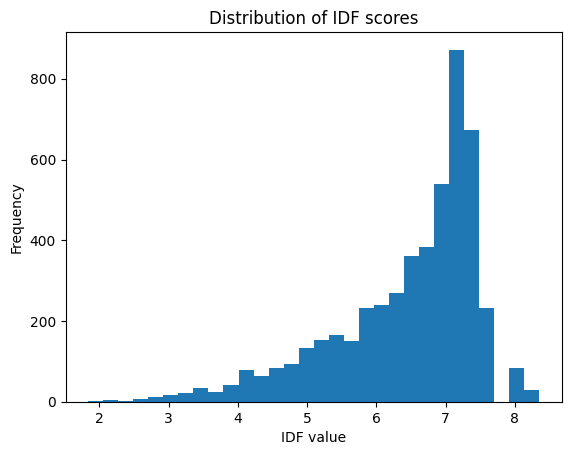

In [ ]:
# Visualize the distribution of IDF scores
idf_scores = tfidf.idf_

plt.hist(idf_scores, bins=30)
plt.title("Distribution of IDF scores")
plt.xlabel("IDF value")
plt.ylabel("Frequency")
plt.show()

- Important word Positive vs Negative
    - Positive reviews
        - Representative words: great, place, time, love, good, best, like, amazing, friendly, awesome
        - Positive reviews contain many emotionally expressive words such as great, love, amazing, and awesome, which show strong positive sentiment.
        - Words related to locations or experience context (e.g., place, time, food, staff) also appear frequently and hold higher importance.
        - Overall, these high-TF-IDF terms clearly convey positive emotions and act as key features for identifying positive sentiment in the dataset.
    - Negative reviews:
        - Representative words: place, food, service, would, back, never, bad, customer, drink, worst
        - Negative reviews highlight service or experience-related complaints, with terms such as service, food, customer, and drink.

        - Strong negative expressions like never, worst, bad, and back indicate dissatisfaction and reinforce negative sentiment.

        - These words focus on specific problems or poor experiences, making them strong indicators for detecting negative sentiment in classification models.

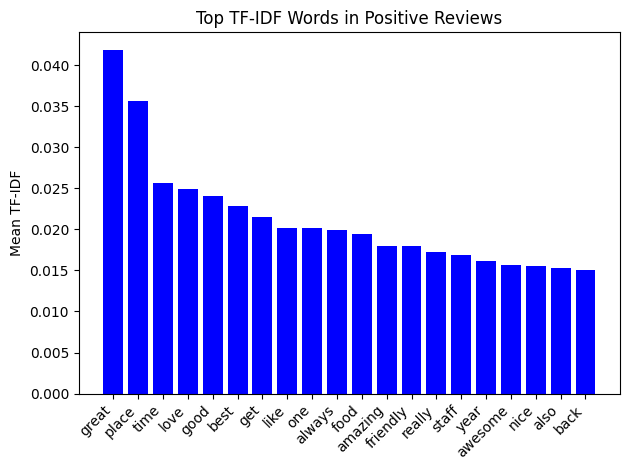

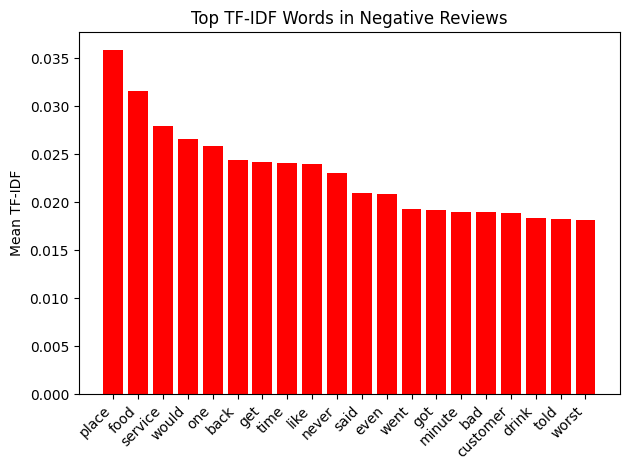

In [ ]:

# Binary masks for positive and negative label
mask_pos = (y_train == 1).values
mask_neg = (y_train == 0).values

# Split TF-IDF matrix by label
X_train_pos = X_train_tfidf[mask_pos]
X_train_neg = X_train_tfidf[mask_neg]

mean_pos = np.asarray(X_train_pos.mean(axis=0)).ravel()
mean_neg = np.asarray(X_train_neg.mean(axis=0)).ravel()


featured_word = tfidf.get_feature_names_out()


top_pos_idx = np.argsort(mean_pos)[-20:][::-1]
top_neg_idx = np.argsort(mean_neg)[-20:][::-1]

top_pos_words = featured_word[top_pos_idx]
top_pos_values = mean_pos[top_pos_idx]

top_neg_words = featured_word[top_neg_idx]
top_neg_values = mean_neg[top_neg_idx]


plt.bar(top_pos_words, top_pos_values, color="blue")
plt.xticks(rotation=45, ha="right")
plt.title("Top TF-IDF Words in Positive Reviews")
plt.ylabel("Mean TF-IDF")
plt.tight_layout()
plt.show()

plt.bar(top_neg_words, top_neg_values, color="red")
plt.xticks(rotation=45, ha="right")
plt.title("Top TF-IDF Words in Negative Reviews")
plt.ylabel("Mean TF-IDF")
plt.tight_layout()
plt.show()


#### Added shared utility functions for model evaluation and visualization.
1. Model evaluation funtion
    - Show accruacy, precision, recall, F1-Score, confusion matrix
        - Accuracy: TP + TN / All components
        - precision: TP/ TP + FP
        - Recall = TP/ TP + FN
        - F1 Score:  the harmonic mean of Precision and Recall
2. Confusion metrix visualization with count for each component

In [19]:
def evaluate_model(y_true, y_pred):
    confusionMatrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:")
    print(confusionMatrix)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}, confusionMatrix


In [20]:
def plot_confusion_matrices(confusionMatrix,title):
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.show()

### Step 3: Baseline Model - Naive Bayes with TF-IDF
**YOU WILL IMPLEMENT:**

- Train a Naive Bayes classifier on the TF-IDF features
- Make predictions on the test set
- Create and visualize a confusion matrix to analyze:
    - True Positives (TP)
    - True Negatives (TN)
    - False Positives (FP)
    - False Negatives (FN)
- Calculate accuracy, precision, recall, and F1-score
- Interpret the results: What types of errors is the model making?

In [14]:
# Import Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

Accuracy : 0.8737
Precision: 0.8478
Recall   : 0.9958
F1-score : 0.9159
Confusion Matrix:
[[193 128]
 [  3 713]]


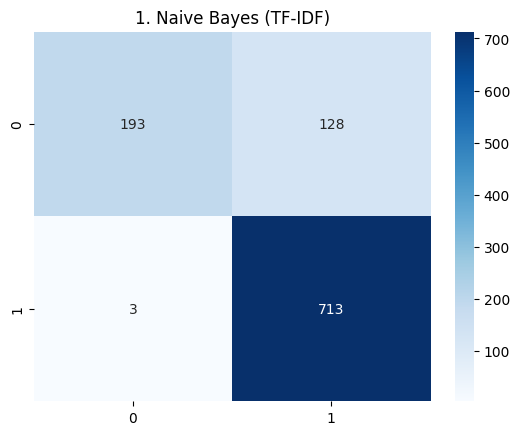

In [21]:
naivBayes = MultinomialNB()
# train the model through TF-IDF features
naivBayes.fit(X_train_tfidf, y_train)

# predict on test set and store predictions
y_prediction_nb = naivBayes.predict(X_test_tfidf)

metrics_nb, confusion_metrix_nb = evaluate_model(y_test, y_prediction_nb)
plot_confusion_matrices(confusion_metrix_nb,"1. Naive Bayes (TF-IDF)")


#### Step 3 Analysis: Naive Bayes Results

**Model Performance:**
- **Accuracy**: 87.37% - The model correctly classifies most reviews
- **Precision**: 84.78% - When the model predicts positive, it's correct 85% of the time
- **Recall**: 99.58% - The model detects nearly all positive reviews (very few false negatives)
- **F1-Score**: 91.59% - Good balance between precision and recall

**Confusion Matrix Interpretation:**
- **True Positives (1→1)**: 713 - Correctly identified positive reviews
- **True Negatives (0→0)**: 193 - Correctly identified negative reviews
- **False Positives (0→1)**: 128 - Negative reviews incorrectly classified as positive
- **False Negatives (1→0)**: 3 - Positive reviews incorrectly classified as negative

**Key Findings:**
- The model excels at detecting positive reviews (Recall 99.58%), missing only 3 positive cases.
- However, it tends to misclassify negative reviews as positive (128 False Positives).
- This suggests the model has a **positive bias**, likely because:
  1. The dataset has more positive reviews (69% vs 31%)
  2. Positive sentiment words may have stronger TF-IDF weights
  3. Naive Bayes assumes feature independence, which may not hold for sentiment

**Error Pattern:**
The 128 false positives indicate the model struggles to identify truly negative reviews, possibly confusing neutral or mixed sentiment as positive. This baseline will be compared with dimensionality reduction methods to see if they improve negative class detection.

### Step 4: Dimensionality Reduction with SVD
- Apply Truncated SVD (Latent Semantic Analysis) to reduce TF-IDF dimensions
- Reduce from ~500-5000 features to 50-100 components
- Visualize the explained variance ratio
- Explain in your markdowns how SVD captures semantic relationships in text, and what it means for your data.


### Step 5: Model Training - Logistic Regression with SVD
**YOU WILL IMPLEMENT:**

- Train a Logistic Regression classifier on SVD-reduced features
- Make predictions on the test set
- Create and visualize a confusion matrix for the SVD model
- Compare performance with the baseline Naive Bayes model
- Analyze: Did dimensionality reduction help or hurt performance?
- Discuss on the markdowns: How does reducing dimensions affect model accuracy and speed?


### Step 6: Dimensionality Reduction with PCA
- Apply Principal Component Analysis (PCA) to the TF-IDF features
- First standardize the data (required for PCA)
- Reduce to the same number of components as SVD for fair comparison
- Compare PCA vs SVD variance curves


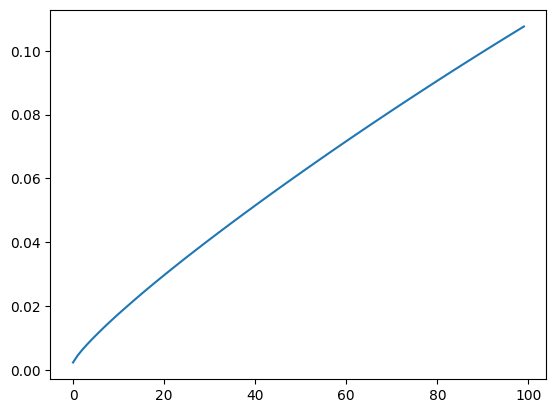

In [ ]:
# PCA requires centering the data (subtracting the mean), which destroys sparsity by transforming zero values into non-zero values.
# Covert sparse matrix(0 in blank) to dense (fill 0 value)
# Reference: https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

# scalar 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled  = scaler.transform(X_test_dense)

# Dimensionality Reduction using PCA and 5000 to 100
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()



### Step 7: Model Training - Logistic Regression with PCA
**YOU WILL IMPLEMENT:**

- Train a Logistic Regression classifier on PCA-reduced features
- Make predictions on the test set
- Create and visualize a confusion matrix for the PCA model
- Compare performance with both previous models
- Analyze: Which dimensionality reduction technique works better for text data?


### Step 8: Visual Comparison
- Visualize all three confusion matrices side-by-side